In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.metrics import r2_score
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.animation as animation # animation
import imageio 
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

In [3]:
datadir ='/Users/francesco/Desktop/Thesis/Data/'

df_bed = xr.open_dataset(datadir + 'BedMachineAntarctica-v3.nc')

In [4]:
surface = df_bed.surface
surface

<xarray.DataArray 'surface' (y: 13333, x: 13333)>
[177768889 values with dtype=float32]
Coordinates:
  * x        (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y        (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Attributes:
    long_name:      ice surface elevation
    standard_name:  surface_altitude
    units:          meters
    grid_mapping:   mapping
    source:         REMA (Byrd Polar and Climate Research Center and the Pola...

In [54]:
import glob
import pandas as pd
import os
from shapely.geometry import shape
import csv
#from mapxy import mapxy
import pyproj
#from ps_latlon_conversion import xyscale_south
import pyproj
#import ogr
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.transform
import rasterio.mask
from fiona import Feature, Geometry
from shapely.geometry import mapping, shape
#from read_tiff import read_tiff
# Open the geotiff file
common_years = np.arange(2000,2018)
common_years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [6]:
#get information from the shp file, without creating the output tif files

path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
lat_lon_coords = []
regions = []
boundaries = []
dem = []



shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])


for feature in shapefile:


    id = feature['properties']['id']
    name=feature['properties']['name']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']

    bounds=shape(geometry).bounds
    xmin=bounds[0];ymin=bounds[1];xmax=bounds[2];ymax=bounds[3]

    surface_subset = surface.sel(x=slice(xmin,xmax), y=slice(ymax,ymin)) # I don't get why for y the coordinates are inverted


    #Taking the info
    ids.append(id)
    Names.append(name)
    lat_lon_coords.append([lat,lon])
    regions.append(region)
    boundaries.append([xmin,xmax,ymin,ymax])
    dem.append(surface_subset)
    #types.append(type)
    #measures.append(measure)


{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'float:24.15', 'mass_los16': 'float:24.15', 'mass_los17': 'floa

In [7]:
#create a dataset with the information retrived from the previous bloc
df = pd.DataFrame({ 'Names':Names, 'lat_lon_coords':lat_lon_coords, 'regions':regions }, index = ids)

# I want to sort this dataset according to the index
df = df.sort_index()


In [8]:
from scipy.signal import medfilt2d

def shadow(dem):
        shaded = np.roll(dem, 1, axis=0) - dem
        shaded = medfilt2d(np.float32(shaded), 1)

        w = np.where(shaded >200)
        shaded[w] = 200

        w = np.where(shaded < -200)
        shaded[w] = -200
        im = np.copy(shaded)

        return im

In [9]:
prova = shadow(dem[0])

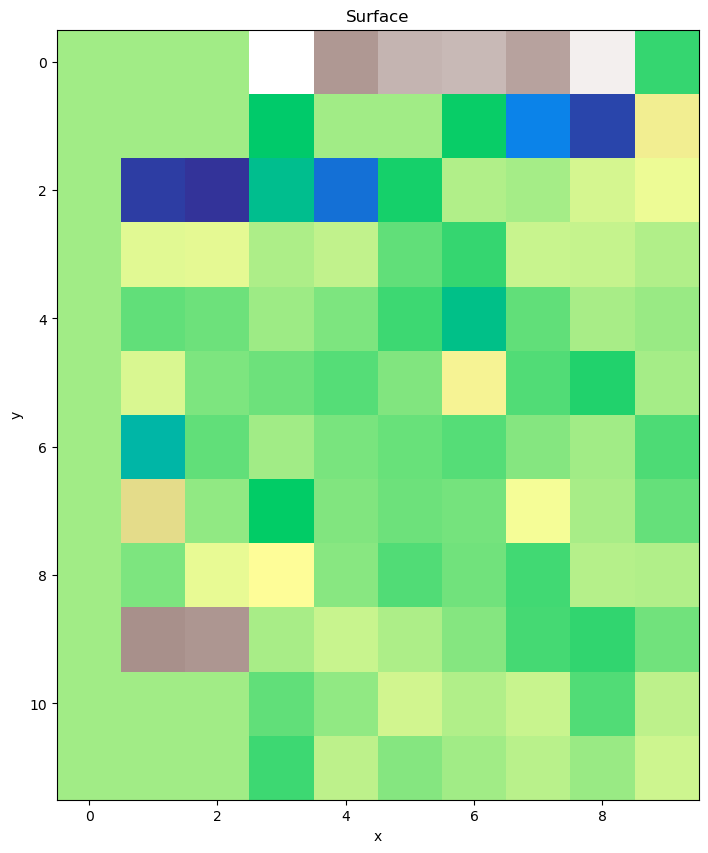

In [10]:
#I want to plot prova, remember is a numpy array
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(prova, cmap='terrain')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Surface')
plt.show()



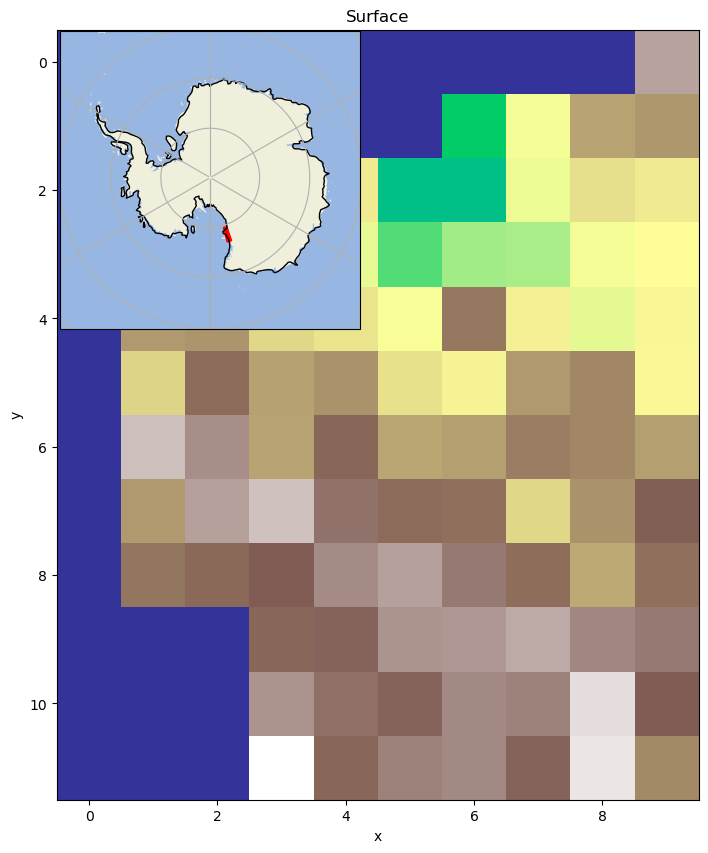

In [11]:

# Create the large plot
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(dem[0], cmap='terrain')
ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Surface')
#plt.show()

# Add the small graph to the top right corner of the large plot
left = 0.195
bottom = 0.58
width = 0.3
height = .3
rect = [left,bottom,width,height]
glacier_lat, glacier_lon = -78.0444, 163.2524

ax2 = fig.add_axes(rect, projection=ccrs.SouthPolarStereo())
ax2.set_extent((-180,180, -90, -60),ccrs.PlateCarree())

ax2.coastlines(resolution='110m', zorder=2)
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.OCEAN)

marker_size = 10
marker_color = 'red'
marker_edge_width = 1
marker_edge_color = 'red'
marker_alpha = 1.0

# Create a rectangle centered on the glacier location
rect_width = 4
rect_height = 3
rect_2 = Rectangle((glacier_lon - rect_width/2, glacier_lat - rect_height/2), 
                rect_width, rect_height,
                facecolor=marker_color, edgecolor=marker_edge_color,
                linewidth=marker_edge_width, alpha=marker_alpha,
                transform=ccrs.PlateCarree())
ax2.add_patch(rect_2)

ax2.gridlines()

plt.show()


In [62]:
datadir ='/Users/francesco/Desktop/Thesis/Data/'
melt_rates = pd.read_excel(datadir + '/Merged_Integrated_melt_rates_with_id_manually_added.xlsx', index_col=0)

common_year = np.arange(2000,2018)
#Select just the common years
melt_rates = melt_rates[common_years]
melt_rates.sort_index

#add df.Names to the melt_rates, at first position
melt_rates.insert(0, 'Names', df.Names)
#melt_rates #seems ok!


In [13]:
def check(number, ids):
    if number in ids:
        return (f'The number {number} is in the list')
    else:
        return (f'The number {number} is not in the list')

In [50]:
check(176,melt_rates.index)

'The number 176 is in the list'

In [51]:
unique = set()
repeated = []

for value in melt_rates.index:
    if value in unique:
        repeated.append(value)
    else:
        unique.add(value)

print("Repeated values:", repeated)

Repeated values: []


In [61]:
common_years = np.arange(2000,2018)
common_years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [55]:
#Here I create the basal melting dataset with the tif data, using rasterio (38 secs)


glacier_tif_df = pd.DataFrame(index = df.index, columns = common_years)

file_path_to_gen_tif = '/Users/francesco/Desktop/Data_exploration/TIF_generated_basal_melting/'


for id in df.index:
    
    for year in common_years:

        file_tif_to_data_set = file_path_to_gen_tif + f"{id}_{year}.tif"

        with rasterio.open(file_tif_to_data_set) as src:
            glacier_tif_df.loc[id, year] = src.read(1)



#save the dataframe as csv
glacier_tif_df.to_csv(os.getcwd() + '/basal_melt_df.csv')



In [56]:
#Here I create 2 calving dataset with the tif data, one for picure and the other for timeserie


calving_tif_df = pd.DataFrame(index = df.index, columns = common_years)
calving_tif_df_cum = pd.DataFrame(index = df.index, columns = common_years)

file_path_to_gen_tif = '/Users/francesco/Desktop/Data_exploration/TIF_Generated_ice_calving/'


for id in ids:
    
    for year in common_years:

        file_tif_to_data_set = file_path_to_gen_tif + f"{id}_{year}.tif"

        with rasterio.open(file_tif_to_data_set) as src:
            calving_tif_df.loc[id, year] = src.read(1)
            calving_tif_df_cum.loc[id, year] = np.nansum(src.read(1))


#save the dataframe as csv
calving_tif_df.to_csv(os.getcwd() + '/calving_tif_df.csv')
calving_tif_df_cum.to_csv(os.getcwd() + '/calving_tif_df_cum.csv')

/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/56244246.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/56244246.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/56244246.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/56244246.py:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(y_ticks)


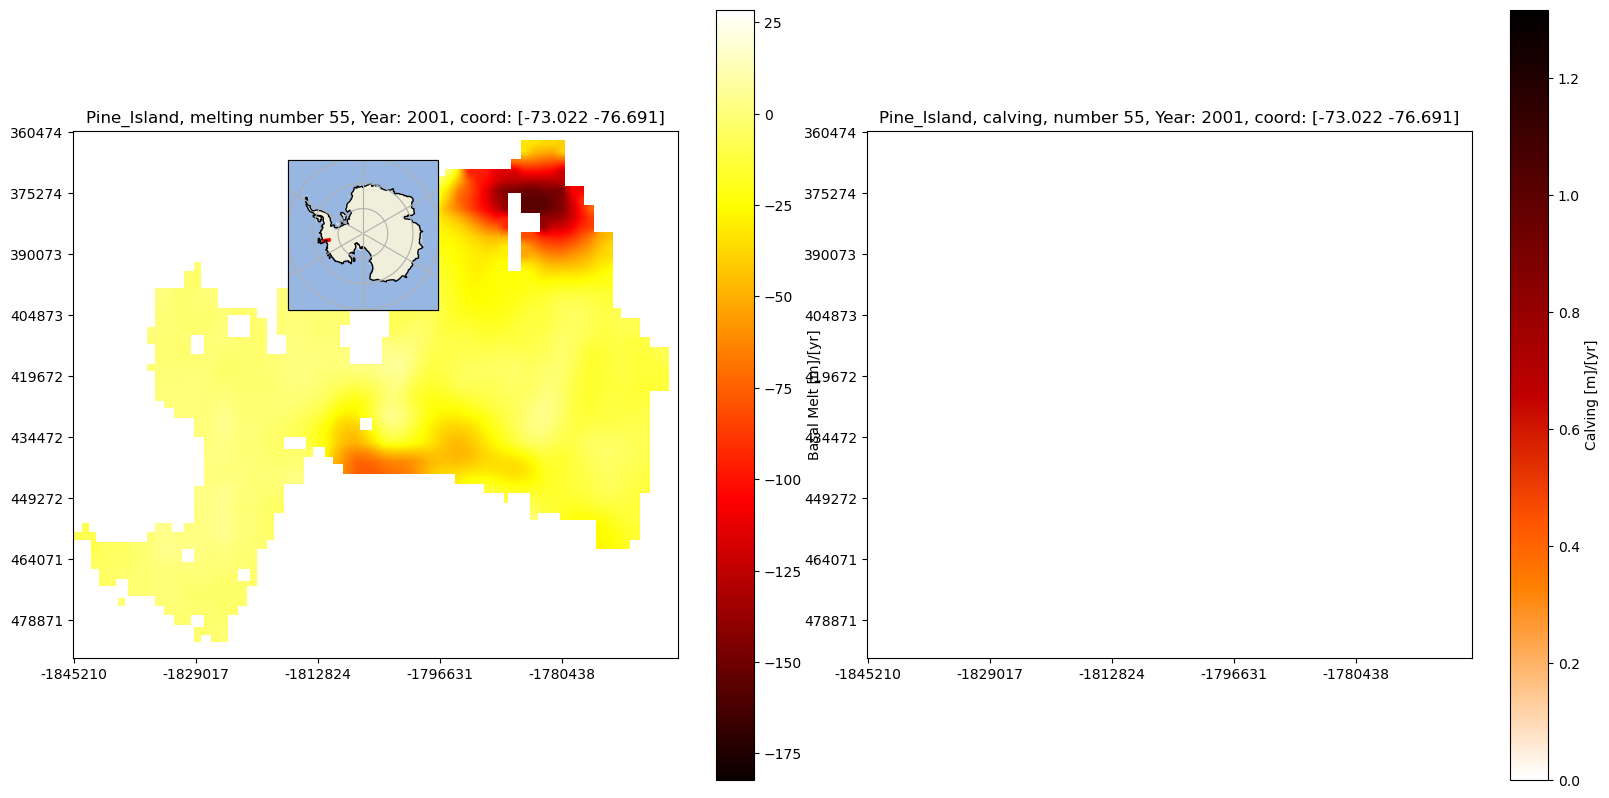

In [19]:

#This is working

id_prova = 55
name = df.Names.loc[id_prova]
glacier_lat, glacier_lon = df.lat_lon_coords.loc[id_prova]

#in this first part i find the max and min, in order to do a proper plot

# Basal Melting
melting_time_series = glacier_tif_df.loc[id_prova]
v_max_bm = 0
v_min_bm = 0

# Calving
calving_time_series = calving_tif_df.loc[id_prova]
v_max_c = 0
v_min_c = 0


for y in common_years:

    # Basal Melting
    melting_time_series_tmp = melting_time_series.loc[y] 
    max_temp_bm = np.nanmax(melting_time_series_tmp)
    min_temp_bm = np.nanmin(melting_time_series_tmp)

    if max_temp_bm > v_max_bm:
        v_max_bm = max_temp_bm
    if min_temp_bm < v_min_bm:
        v_min_bm = min_temp_bm   


    # Calving
    calving_time_series_tmp = calving_time_series.loc[y]
    max_temp_c = np.nanmax(calving_time_series_tmp)
    min_temp_c = np.nanmin(calving_time_series_tmp)

    if max_temp_c > v_max_c:
        v_max_c = max_temp_c
    if min_temp_c < v_min_c:
        v_min_c = min_temp_c



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.subplots_adjust(wspace=0.05, hspace=0.05)

#Axis ticks are not working, I need to fix them. The problem is that the x ticks are not in the right place
x_ticks = np.linspace(boundaries[id_prova][0], boundaries[id_prova][1], 10, dtype = int)
y_ticks = np.linspace(boundaries[id_prova][2], boundaries[id_prova][3], 10, dtype = int)

#Plotting the Basal Melting

im1 = ax1.imshow(melting_time_series[common_years[0]], cmap = 'hot' , vmin=v_min_bm, vmax=v_max_bm)
cbar1 = fig.colorbar(im1, ax=ax1)
cbar1.set_label('Basal Melt [m]/[yr]')
ax1.set_xticklabels(x_ticks)
ax1.set_yticklabels(y_ticks)


#Plotting the Calving

im2 = ax2.imshow(calving_time_series[common_years[0]], cmap = 'gist_heat_r' , vmin=v_min_c, vmax=v_max_c)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('Calving [m]/[yr]')
ax2.set_xticklabels(x_ticks)
ax2.set_yticklabels(y_ticks)


frames = []

#To shoerten the code
#common_years = np.arange(2000, 2002, 1)

for y in common_years:

    #Basal melting
    im1.set_data(melting_time_series.loc[y])
    ax1.set_title(f"{name}, melting number {id_prova}, Year: {y}, coord: {np.round(lat_lon_coords[id_prova],3)}")

    #Calving
    im2.set_data(calving_time_series.loc[y])
    ax2.set_title(f"{name}, calving, number {id_prova}, Year: {y}, coord: {np.round(lat_lon_coords[id_prova],3)}")

    #small Image
    left = 0.195
    bottom = 0.58
    width = 0.15
    height = 0.15
    rect = [left,bottom,width,height]

    ax4 = fig.add_axes(rect, projection=ccrs.SouthPolarStereo())
    ax4.set_extent((-180,180, -90, -60),ccrs.PlateCarree())

    ax4.coastlines(resolution='110m', zorder=2)
    ax4.add_feature(cfeature.LAND)
    ax4.add_feature(cfeature.OCEAN)

    marker_size = 5
    marker_color = 'red'
    marker_edge_width = 1
    marker_edge_color = 'red'
    marker_alpha = 1.0

    # Create a rectangle centered on the glacier location
    rect_width = 4
    rect_height = 3
    rect_2 = Rectangle((glacier_lon - rect_width/2, glacier_lat - rect_height/2), 
                    rect_width, rect_height,
                    facecolor=marker_color, edgecolor=marker_edge_color,
                    linewidth=marker_edge_width, alpha=marker_alpha,
                    transform=ccrs.PlateCarree())
    ax4.add_patch(rect_2)

    ax4.gridlines()
    #end of the small image


    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

imageio.mimsave('glacier_prova.gif', frames, fps=2)



In [128]:
calving_rates_cum_id[:i+1]

2000    65.531503
2001          0.0
2002    66.771153
2003          0.0
2004    30.731326
2005     48.39634
2006    69.640343
2007    46.106986
2008    93.933486
2009          0.0
2010    51.035595
2011    35.769903
2012    48.436328
2013    52.225259
2014          0.0
2015     45.80707
2016          0.0
2017    45.457169
Name: 55, dtype: object

/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/1838341289.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/1838341289.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(y_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/1838341289.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(x_ticks)
/var/folders/9n/18cd5sld4lv1jvk0nw84p_bh0000gq/T/ipykernel_23699/1838341289.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(y_ticks)


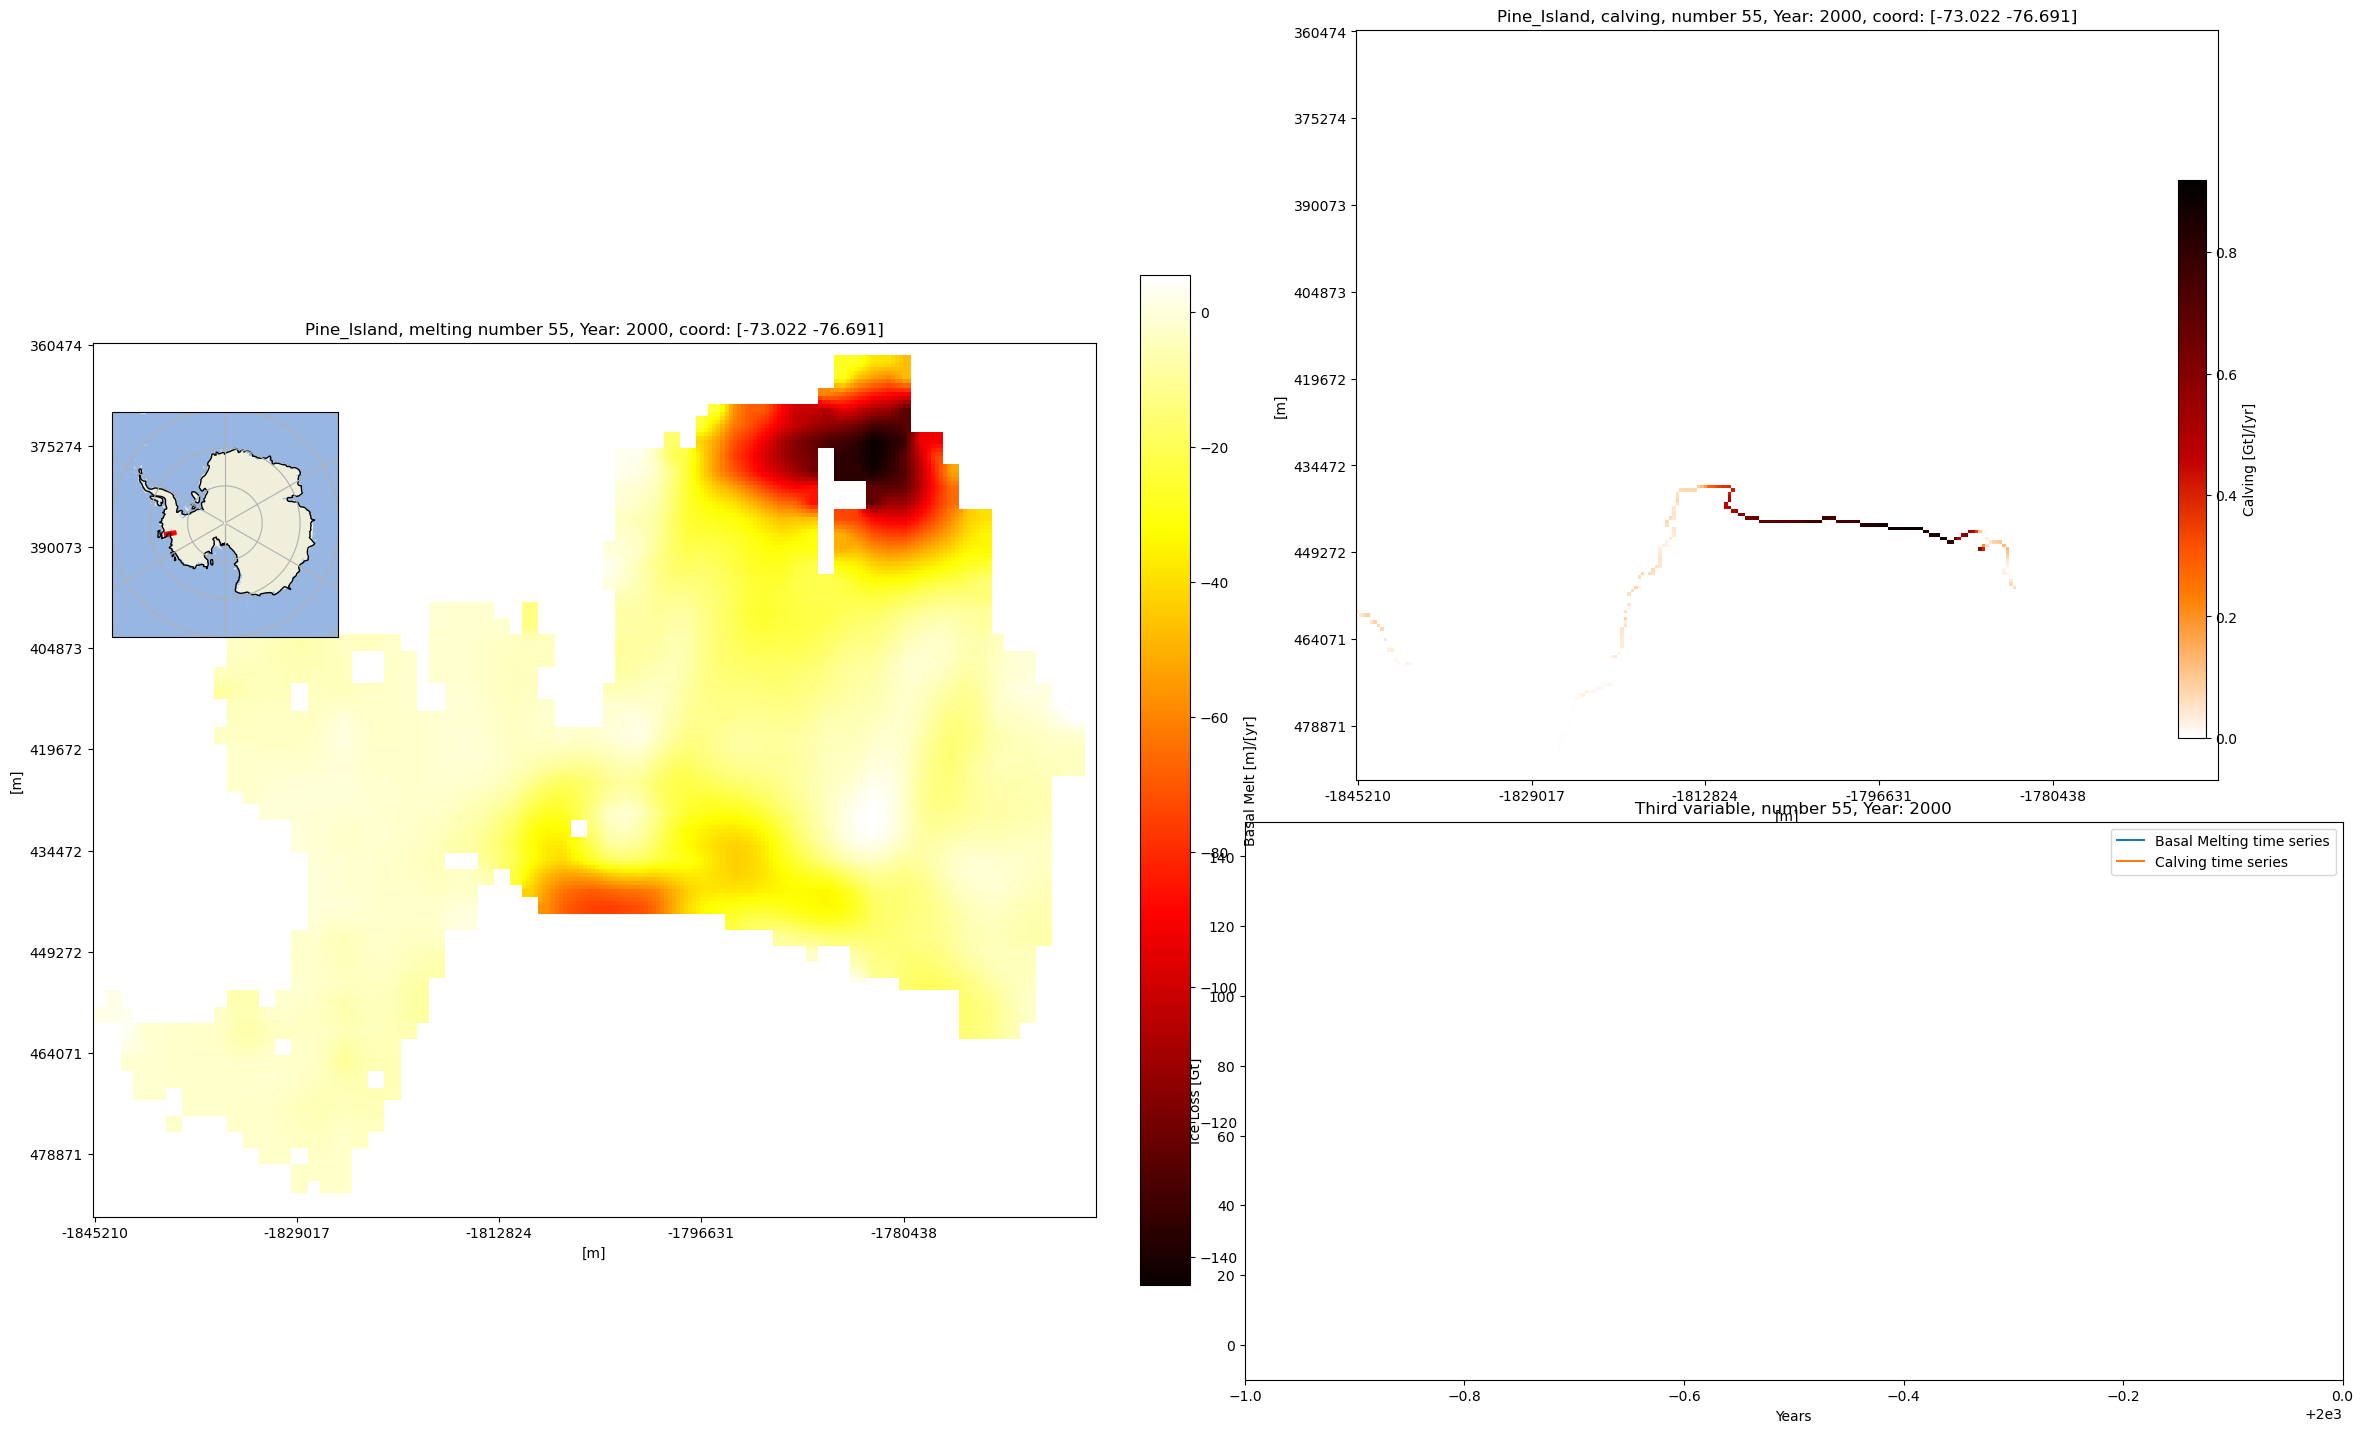

In [186]:
#    !!!!!!!!!CHECK MEASURE UNIT!!!!!!!!!
#Experimenting with the plot. I NEED TO ADD melt_rates and calving_rates and calving_tif_df_cum

id_prova = 55
name = df.Names.loc[id_prova]
glacier_lat, glacier_lon = df.lat_lon_coords.loc[id_prova]

#in this first part i find the max and min, in order to do a proper plot

# Basal Melting
melting_time_series = glacier_tif_df.loc[id_prova]
melt_rates_id = melt_rates.loc[id_prova]

v_max_bm = 0
v_min_bm = 0

# Calving
calving_time_series = calving_tif_df.loc[id_prova]
calving_rates_cum_id = calving_tif_df_cum.loc[id_prova]
v_max_c = 0
v_min_c = 0


for y in common_years:

    # Basal Melting
    melting_time_series_tmp = melting_time_series.loc[y] 
    max_temp_bm = np.nanmax(melting_time_series_tmp)
    min_temp_bm = np.nanmin(melting_time_series_tmp)

    if max_temp_bm > v_max_bm:
        v_max_bm = max_temp_bm
    if min_temp_bm < v_min_bm:
        v_min_bm = min_temp_bm   


    # Calving
    calving_time_series_tmp = calving_time_series.loc[y]
    max_temp_c = np.nanmax(calving_time_series_tmp)
    min_temp_c = np.nanmin(calving_time_series_tmp)

    if max_temp_c > v_max_c:
        v_max_c = max_temp_c
    if min_temp_c < v_min_c:
        v_min_c = min_temp_c



fig = plt.figure(figsize=(25, 15))


ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,4)

#Axis ticks are not working, I need to fix them. The problem is that the x ticks are not in the right place
x_ticks = np.linspace(boundaries[id_prova][0], boundaries[id_prova][1], 10, dtype = int)
y_ticks = np.linspace(boundaries[id_prova][2], boundaries[id_prova][3], 10, dtype = int)

#Plotting the Basal Melting
im1 = ax1.imshow(melting_time_series[common_years[0]], cmap = 'hot' , vmin=v_min_bm, vmax=v_max_bm)
cbar1 = fig.colorbar(im1, ax=ax1, fraction = 0.046, pad = 0.04)
cbar1.set_label('Basal Melt [m]/[yr]')
ax1.set_xticklabels(x_ticks)
ax1.set_yticklabels(y_ticks)
ax1.set_title(f"{name}, melting number {id_prova}, Year: {common_years[0]}, coord: {np.round(lat_lon_coords[id_prova],3)}")
ax1.set_xlabel('[m]')
ax1.set_ylabel('[m]')



#Plotting the Calving
im2 = ax2.imshow(calving_time_series[common_years[0]], cmap = 'gist_heat_r' , vmin=v_min_c, vmax=v_max_c)
cbar2 = fig.colorbar(im2, ax=ax2)
cbar2.set_label('Calving [Gt]/[yr]') #CHECK THIS
ax2.set_xticklabels(x_ticks)
ax2.set_yticklabels(y_ticks)
ax2.set_title(f"{name}, calving, number {id_prova}, Year: {y}, coord: {np.round(lat_lon_coords[id_prova],3)}")
ax2.set_xlabel('[m]')
ax2.set_ylabel('[m]')
ax2.set_position([0.55, 0.1, 0.6, 0.8])

#Time series
ax3.set_title(f"Third variable, number {id_prova}, Year: {y}")
ax3.set_xlim(common_years[0]-1, common_years[-1])
ax3.set_ylim(-10, 150)
ax3.set_xlabel('Years')
ax3.set_ylabel('Ice Loss [Gt]')

ax3.plot( melt_rates_id[1:2], label = 'Basal Melting time series')
ax3.plot(calving_rates_cum_id[1:2], label = 'Calving time series')
ax3.legend()


#fig.subplots_adjust(wspace=0.05, hspace=0.05, top=0.9, bottom=0.1, left=0.05, right=0.95)
fig.subplots_adjust(wspace=0.05, hspace=0.15, top=0.9, bottom=0.1, left=0.05, right=0.95)

frames = []

#To shoerten the code
common_years = np.arange(2000, 2001, 1)

i = 2

for y in common_years:

    #Basal melting
    #ax1.set_position([0, 0, 0.5, 0.5])
    im1.set_data(melting_time_series.loc[y])


    #Calving
    ax2.set_position([0.5, 0.5, 0.4, 0.5])
    im2.set_data(calving_time_series.loc[y])

    ax3.plot( melt_rates_id[1:i], label = 'Basal Melting time series', color = 'blue')
    ax3.plot(calving_rates_cum_id[1:i], label = 'Calving time series', color = 'orange')



    #small Image
    left = 0.028
    bottom = 0.595
    width = 0.15
    height = 0.15
    rect = [left,bottom,width,height]

    ax4 = fig.add_axes(rect, projection=ccrs.SouthPolarStereo())
    ax4.set_extent((-180,180, -90, -60),ccrs.PlateCarree())

    ax4.coastlines(resolution='110m', zorder=2)
    ax4.add_feature(cfeature.LAND)
    ax4.add_feature(cfeature.OCEAN)

    marker_size = 5
    marker_color = 'red'
    marker_edge_width = 1
    marker_edge_color = 'red'
    marker_alpha = 1.0

    # Create a rectangle centered on the glacier location
    rect_width = 4
    rect_height = 3
    rect_2 = Rectangle((glacier_lon - rect_width/2, glacier_lat - rect_height/2), 
                    rect_width, rect_height,
                    facecolor=marker_color, edgecolor=marker_edge_color,
                    linewidth=marker_edge_width, alpha=marker_alpha,
                    transform=ccrs.PlateCarree())
    ax4.add_patch(rect_2)

    ax4.gridlines()
    #end of the small image


    fig.canvas.draw()
    frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    frames.append(frame)

    i =i +1

imageio.mimsave('glacier_prova.gif', frames, fps=2)



In [149]:
# Select first row of firstmelt_rates_id, including the year
print(melt_rates_id[1:2])

2000    90.2
Name: 55.0, dtype: object


In [112]:
melt_rates_id[:common_years[i]+1].plot()

#From melt_rates_id[1:common_years[i]+1] I want to select just the values, not the years

TypeError: no numeric data to plot

In [ ]:

    # ---------------------------------Locating Map ------------------------
    #
    # set up index map 20% height, left 16% of figure
    left = 0
    bottom = 0
    width = 0.48
    height = 0.6
    rect = [left,bottom,width,height]
    glacier_lat, glacier_lon = -78.0444, 163.2524


    ax2 = plt.axes(rect, projection=ccrs.SouthPolarStereo())
    ax2.set_extent((-180,180, -90, -60),ccrs.PlateCarree())

    ax2.coastlines(resolution='110m', zorder=2)
    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.OCEAN)
    #ax2.plot(glacier_lon, glacier_lat, 'ro', markersize=10, transform=ccrs.PlateCarree())
    

    marker_size = 10
    marker_color = 'red'
    marker_edge_width = 1
    marker_edge_color = 'red'
    marker_alpha = 1.0

    # Create a rectangle centered on the glacier location
    rect_width = 4
    rect_height = 3
    rect_2 = Rectangle((glacier_lon - rect_width/2, glacier_lat - rect_height/2), 
                    rect_width, rect_height,
                    facecolor=marker_color, edgecolor=marker_edge_color,
                    linewidth=marker_edge_width, alpha=marker_alpha,
                    transform=ccrs.PlateCarree())
    ax2.add_patch(rect_2)

    ax2.gridlines()